# The Deep Learning Homework 3 - Question No. 04 Part B
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                                          
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12878099.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define a Convolutional Neural Network

In [2]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [5]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [6]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(model)

6640202

## Train the network

In [8]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [9]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [10]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:23<00:00, 66.52it/s]


Train Loss: 2.045 | Accuracy: 20.132


100%|██████████| 313/313 [00:03<00:00, 91.96it/s]


Test Loss: 1.631 | Accuracy: 34.900

Epoch : 2


100%|██████████| 1563/1563 [00:24<00:00, 64.95it/s]


Train Loss: 1.302 | Accuracy: 50.652


100%|██████████| 313/313 [00:03<00:00, 93.01it/s]


Test Loss: 0.999 | Accuracy: 63.750

Epoch : 3


100%|██████████| 1563/1563 [00:23<00:00, 67.69it/s]


Train Loss: 0.861 | Accuracy: 68.708


100%|██████████| 313/313 [00:03<00:00, 94.27it/s]


Test Loss: 0.789 | Accuracy: 72.340

Epoch : 4


100%|██████████| 1563/1563 [00:23<00:00, 67.60it/s]


Train Loss: 0.644 | Accuracy: 77.054


100%|██████████| 313/313 [00:03<00:00, 94.90it/s]


Test Loss: 0.697 | Accuracy: 75.420

Epoch : 5


100%|██████████| 1563/1563 [00:23<00:00, 67.89it/s]


Train Loss: 0.490 | Accuracy: 82.850


100%|██████████| 313/313 [00:03<00:00, 94.92it/s]


Test Loss: 0.624 | Accuracy: 78.760

Epoch : 6


100%|██████████| 1563/1563 [00:23<00:00, 67.22it/s]


Train Loss: 0.372 | Accuracy: 86.916


100%|██████████| 313/313 [00:03<00:00, 92.75it/s]


Test Loss: 0.733 | Accuracy: 77.130

Epoch : 7


100%|██████████| 1563/1563 [00:22<00:00, 68.57it/s]


Train Loss: 0.272 | Accuracy: 90.598


100%|██████████| 313/313 [00:03<00:00, 80.35it/s]


Test Loss: 0.690 | Accuracy: 78.250

Epoch : 8


100%|██████████| 1563/1563 [00:22<00:00, 69.47it/s]


Train Loss: 0.207 | Accuracy: 92.722


100%|██████████| 313/313 [00:04<00:00, 70.45it/s]


Test Loss: 0.725 | Accuracy: 79.410

Epoch : 9


100%|██████████| 1563/1563 [00:22<00:00, 70.76it/s]


Train Loss: 0.147 | Accuracy: 94.860


100%|██████████| 313/313 [00:04<00:00, 71.47it/s]


Test Loss: 0.779 | Accuracy: 79.430

Epoch : 10


100%|██████████| 1563/1563 [00:22<00:00, 70.38it/s]


Train Loss: 0.117 | Accuracy: 95.876


100%|██████████| 313/313 [00:04<00:00, 75.12it/s]


Test Loss: 0.839 | Accuracy: 78.620

Epoch : 11


100%|██████████| 1563/1563 [00:23<00:00, 67.19it/s]


Train Loss: 0.085 | Accuracy: 97.072


100%|██████████| 313/313 [00:03<00:00, 87.93it/s]


Test Loss: 0.857 | Accuracy: 80.560

Epoch : 12


100%|██████████| 1563/1563 [00:23<00:00, 66.90it/s]


Train Loss: 0.069 | Accuracy: 97.596


100%|██████████| 313/313 [00:03<00:00, 95.11it/s] 


Test Loss: 0.869 | Accuracy: 80.370

Epoch : 13


100%|██████████| 1563/1563 [00:23<00:00, 67.22it/s]


Train Loss: 0.051 | Accuracy: 98.268


100%|██████████| 313/313 [00:03<00:00, 93.67it/s]


Test Loss: 0.945 | Accuracy: 79.800

Epoch : 14


100%|██████████| 1563/1563 [00:23<00:00, 67.05it/s]


Train Loss: 0.041 | Accuracy: 98.590


100%|██████████| 313/313 [00:03<00:00, 93.49it/s]


Test Loss: 0.964 | Accuracy: 80.310

Epoch : 15


100%|██████████| 1563/1563 [00:23<00:00, 67.22it/s]


Train Loss: 0.044 | Accuracy: 98.492


100%|██████████| 313/313 [00:03<00:00, 93.22it/s]


Test Loss: 0.927 | Accuracy: 81.130

Epoch : 16


100%|██████████| 1563/1563 [00:23<00:00, 67.58it/s]


Train Loss: 0.040 | Accuracy: 98.582


100%|██████████| 313/313 [00:03<00:00, 93.31it/s]


Test Loss: 0.952 | Accuracy: 81.670

Epoch : 17


100%|██████████| 1563/1563 [00:23<00:00, 66.74it/s]


Train Loss: 0.028 | Accuracy: 99.040


100%|██████████| 313/313 [00:03<00:00, 90.83it/s]


Test Loss: 1.038 | Accuracy: 81.450

Epoch : 18


100%|██████████| 1563/1563 [00:23<00:00, 67.30it/s]


Train Loss: 0.021 | Accuracy: 99.310


100%|██████████| 313/313 [00:03<00:00, 90.46it/s]


Test Loss: 1.105 | Accuracy: 80.270

Epoch : 19


100%|██████████| 1563/1563 [00:22<00:00, 68.30it/s]


Train Loss: 0.019 | Accuracy: 99.324


100%|██████████| 313/313 [00:04<00:00, 77.70it/s]


Test Loss: 1.017 | Accuracy: 81.570

Epoch : 20


100%|██████████| 1563/1563 [00:22<00:00, 69.49it/s]


Train Loss: 0.012 | Accuracy: 99.618


100%|██████████| 313/313 [00:04<00:00, 71.02it/s]


Test Loss: 1.064 | Accuracy: 82.070

Epoch : 21


100%|██████████| 1563/1563 [00:22<00:00, 69.25it/s]


Train Loss: 0.012 | Accuracy: 99.616


100%|██████████| 313/313 [00:04<00:00, 72.81it/s]


Test Loss: 1.125 | Accuracy: 82.190

Epoch : 22


100%|██████████| 1563/1563 [00:23<00:00, 66.41it/s]


Train Loss: 0.019 | Accuracy: 99.332


100%|██████████| 313/313 [00:03<00:00, 92.70it/s]


Test Loss: 1.155 | Accuracy: 81.160

Epoch : 23


100%|██████████| 1563/1563 [00:23<00:00, 67.06it/s]


Train Loss: 0.023 | Accuracy: 99.266


100%|██████████| 313/313 [00:03<00:00, 89.28it/s]


Test Loss: 1.053 | Accuracy: 82.010

Epoch : 24


100%|██████████| 1563/1563 [00:24<00:00, 64.15it/s]


Train Loss: 0.019 | Accuracy: 99.364


100%|██████████| 313/313 [00:03<00:00, 88.62it/s]


Test Loss: 1.053 | Accuracy: 82.060

Epoch : 25


100%|██████████| 1563/1563 [00:23<00:00, 65.83it/s]


Train Loss: 0.015 | Accuracy: 99.506


100%|██████████| 313/313 [00:03<00:00, 92.56it/s]


Test Loss: 1.106 | Accuracy: 81.900

Epoch : 26


100%|██████████| 1563/1563 [00:23<00:00, 66.52it/s]


Train Loss: 0.008 | Accuracy: 99.734


100%|██████████| 313/313 [00:03<00:00, 89.66it/s]


Test Loss: 1.106 | Accuracy: 82.320

Epoch : 27


100%|██████████| 1563/1563 [00:23<00:00, 66.07it/s]


Train Loss: 0.005 | Accuracy: 99.854


100%|██████████| 313/313 [00:03<00:00, 85.00it/s]


Test Loss: 1.187 | Accuracy: 82.010

Epoch : 28


100%|██████████| 1563/1563 [00:23<00:00, 67.18it/s]


Train Loss: 0.003 | Accuracy: 99.918


100%|██████████| 313/313 [00:04<00:00, 70.17it/s]


Test Loss: 1.165 | Accuracy: 82.070

Epoch : 29


100%|██████████| 1563/1563 [00:22<00:00, 68.68it/s]


Train Loss: 0.004 | Accuracy: 99.876


100%|██████████| 313/313 [00:04<00:00, 69.65it/s]


Test Loss: 1.146 | Accuracy: 82.540

Epoch : 30


100%|██████████| 1563/1563 [00:23<00:00, 65.69it/s]


Train Loss: 0.003 | Accuracy: 99.912


100%|██████████| 313/313 [00:03<00:00, 92.89it/s] 


Test Loss: 1.158 | Accuracy: 82.770

Epoch : 31


100%|██████████| 1563/1563 [00:23<00:00, 65.59it/s]


Train Loss: 0.002 | Accuracy: 99.952


100%|██████████| 313/313 [00:03<00:00, 94.06it/s]


Test Loss: 1.152 | Accuracy: 83.260

Epoch : 32


100%|██████████| 1563/1563 [00:23<00:00, 66.60it/s]


Train Loss: 0.001 | Accuracy: 99.970


100%|██████████| 313/313 [00:03<00:00, 89.63it/s]


Test Loss: 1.196 | Accuracy: 83.040

Epoch : 33


100%|██████████| 1563/1563 [00:23<00:00, 65.63it/s]


Train Loss: 0.000 | Accuracy: 99.992


100%|██████████| 313/313 [00:03<00:00, 90.90it/s]


Test Loss: 1.185 | Accuracy: 83.210

Epoch : 34


100%|██████████| 1563/1563 [00:23<00:00, 65.71it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 90.39it/s]


Test Loss: 1.197 | Accuracy: 83.440

Epoch : 35


100%|██████████| 1563/1563 [00:24<00:00, 64.75it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 76.91it/s]


Test Loss: 1.190 | Accuracy: 83.570

Epoch : 36


100%|██████████| 1563/1563 [00:23<00:00, 67.74it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 69.54it/s]


Test Loss: 1.204 | Accuracy: 83.490

Epoch : 37


100%|██████████| 1563/1563 [00:22<00:00, 69.76it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 68.82it/s]


Test Loss: 1.199 | Accuracy: 83.610

Epoch : 38


100%|██████████| 1563/1563 [00:22<00:00, 68.22it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.88it/s]


Test Loss: 1.208 | Accuracy: 83.620

Epoch : 39


100%|██████████| 1563/1563 [00:23<00:00, 66.82it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.29it/s]


Test Loss: 1.209 | Accuracy: 83.600

Epoch : 40


100%|██████████| 1563/1563 [00:23<00:00, 66.41it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 94.98it/s]


Test Loss: 1.211 | Accuracy: 83.600

Epoch : 41


100%|██████████| 1563/1563 [00:23<00:00, 67.16it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.85it/s] 


Test Loss: 1.214 | Accuracy: 83.610

Epoch : 42


100%|██████████| 1563/1563 [00:23<00:00, 67.44it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 95.06it/s]


Test Loss: 1.223 | Accuracy: 83.690

Epoch : 43


100%|██████████| 1563/1563 [00:23<00:00, 67.37it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.50it/s]


Test Loss: 1.225 | Accuracy: 83.680

Epoch : 44


100%|██████████| 1563/1563 [00:23<00:00, 67.09it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 92.58it/s]


Test Loss: 1.234 | Accuracy: 83.550

Epoch : 45


100%|██████████| 1563/1563 [00:23<00:00, 66.96it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 87.48it/s]


Test Loss: 1.236 | Accuracy: 83.660

Epoch : 46


100%|██████████| 1563/1563 [00:23<00:00, 67.88it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 71.03it/s]


Test Loss: 1.240 | Accuracy: 83.520

Epoch : 47


100%|██████████| 1563/1563 [00:22<00:00, 70.90it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 71.63it/s]


Test Loss: 1.244 | Accuracy: 83.620

Epoch : 48


100%|██████████| 1563/1563 [00:22<00:00, 69.87it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 79.47it/s]


Test Loss: 1.243 | Accuracy: 83.670

Epoch : 49


100%|██████████| 1563/1563 [00:23<00:00, 67.11it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 89.89it/s]


Test Loss: 1.247 | Accuracy: 83.460

Epoch : 50


100%|██████████| 1563/1563 [00:23<00:00, 66.93it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 93.42it/s]

Test Loss: 1.235 | Accuracy: 83.650


## Drowing plots

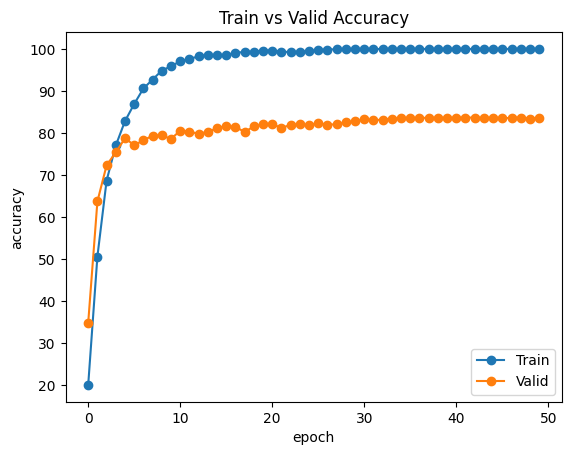

In [11]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

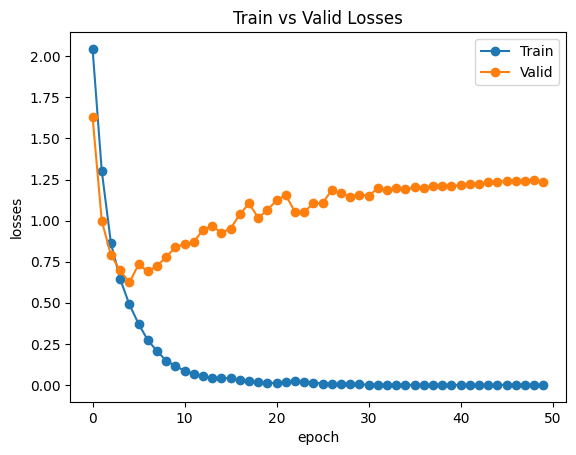

In [12]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [13]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:03<00:00, 89.46it/s]


In [14]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 4, 3, 5, 0, 9, 6, 6, 5, 2, 6, 9, 8, 4, 1, 9, 5, 4, 6, 7, 6, 0, 9, 3, 9, 7, 6, 9, 8, 7, 3, 8, 8, 7, 5, 5, 3, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 5, 8, 8, 1, 1, 7, 5, 7, 2, 0, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 7, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 3, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 3, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 0, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 3, 4, 5, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 8, 2, 2, 5, 5, 9, 9, 2, 0, 3, 0, 8, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 7, 0, 7, 4, 3, 9, 0, 6, 1, 9, 9, 1, 0, 7, 9, 1, 2, 6, 1, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 4, 8, 6, 0, 2, 3, 0, 7, 7, 5, 5, 3, 5, 2, 2, 7, 1, 7, 5, 4, 6, 1, 9, 6, 

In [15]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [16]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [17]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,869,8,38,18,13,1,4,5,30,14
automobile,8,921,1,4,3,2,4,3,17,37
bird,49,0,763,39,50,46,32,15,4,2
cat,20,2,54,698,41,109,44,21,9,2
deer,10,3,42,36,829,18,28,27,5,2
dog,6,0,27,138,25,748,11,41,2,2
frog,3,3,21,43,19,12,888,2,4,5
horse,15,2,15,30,35,37,1,856,1,8
ship,40,8,13,11,1,0,2,4,907,14
truck,25,53,1,6,2,0,4,10,13,886


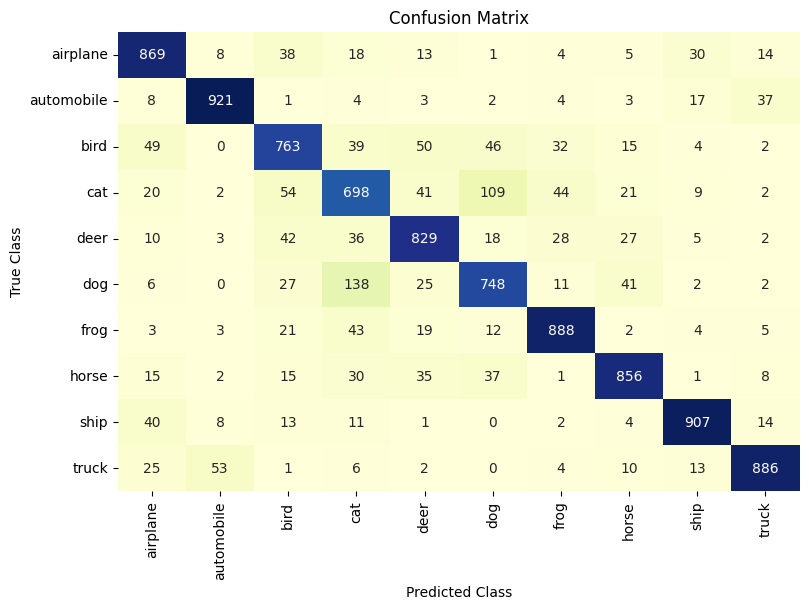

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()